<a href="https://colab.research.google.com/github/qkqclsrn1/CNN/blob/main/Multi_Label_Image_Classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 각 코드 셀의 실행시간 측정 모듈
!pip install ipython-autotime

%load_ext autotime

time: 1.69 ms (started: 2021-06-03 07:16:31 +00:00)


In [2]:
# Python import

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from keras import Sequential
from keras.layers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

time: 7.36 s (started: 2021-06-03 07:16:32 +00:00)


In [3]:
# Load Data

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive
time: 1.12 s (started: 2021-06-03 07:16:42 +00:00)


In [4]:
train = pd.read_csv('/content/drive/MyDrive/classification/train.csv',encoding='cp949')
test = pd.read_csv('/content/drive/MyDrive/classification/test.csv',encoding='cp949')
submission = pd.read_csv('/content/drive/MyDrive/classification/submission.csv',encoding='cp949')

time: 1.66 s (started: 2021-06-03 07:16:45 +00:00)


In [5]:
# EDA

print("데이터의 형태(행, 열):", train.shape) 
train.head()

데이터의 형태(행, 열): (2048, 787)


,id,digit,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,1,5,L,1,1,1,4,3,0,0,4,4,3,0,4,3,3,3,4,4,0,0,1,1,3,4,0,4,2,0,4,0,1,3,1,0,4,1,1,3,...,4,3,4,1,3,0,0,1,3,3,3,0,3,2,2,1,0,1,0,0,3,0,0,4,2,0,3,4,1,1,2,1,0,1,2,4,4,4,3,4
1,2,0,B,0,4,0,0,4,1,1,1,4,2,0,3,4,0,0,2,3,4,0,3,4,3,0,2,2,1,4,2,3,3,4,1,2,4,2,0,3,...,4,2,3,0,0,0,0,4,3,2,2,4,2,1,1,1,3,3,1,2,4,4,4,2,2,4,4,0,4,2,0,3,0,1,4,1,4,2,1,2
2,3,4,L,1,1,2,2,1,1,1,0,2,1,3,2,2,2,4,1,1,4,1,0,1,3,4,2,2,2,4,1,1,2,0,3,0,2,3,4,0,...,3,0,4,0,3,0,2,0,1,4,2,3,4,4,4,0,2,0,4,4,1,3,0,3,2,0,2,3,0,2,3,3,3,0,2,0,3,0,2,2
3,4,9,D,1,2,0,2,0,4,0,3,4,3,1,0,3,2,2,0,3,4,1,0,4,1,2,2,3,2,2,0,2,0,3,0,3,2,4,0,0,...,0,3,0,1,4,1,3,1,2,1,1,1,2,2,2,4,3,4,3,0,4,1,2,4,1,4,0,1,0,4,3,3,2,0,1,4,0,0,1,1
4,5,6,A,3,0,2,4,0,3,0,4,2,4,2,1,4,1,1,4,4,0,2,3,4,4,3,3,3,3,4,1,0,3,0,3,0,0,0,1,1,...,2,1,3,2,1,4,2,3,2,2,1,0,4,2,2,1,2,1,0,3,2,2,2,2,1,4,2,1,2,1,4,4,3,2,1,3,4,3,1,2


time: 81.6 ms (started: 2021-06-03 07:16:52 +00:00)


In [6]:
print("데이터의 형태(행, 열):", test.shape) 
test.head()

데이터의 형태(행, 열): (20480, 786)


,id,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,2049,L,0,4,0,2,4,2,3,1,0,0,1,0,1,3,4,4,0,0,2,4,4,1,3,3,2,2,4,1,0,1,2,2,1,2,2,1,4,0,...,1,3,1,1,3,3,4,1,3,1,2,4,1,2,0,3,1,2,4,0,2,1,2,4,1,1,3,2,1,0,2,0,4,2,2,4,3,4,1,4
1,2050,C,4,1,4,0,1,1,0,2,2,1,0,3,0,1,1,4,1,2,0,2,2,0,4,3,4,0,2,4,4,2,1,2,4,0,4,2,0,2,...,3,4,2,6,2,2,0,1,2,4,1,1,3,3,2,3,4,2,2,4,3,1,3,3,3,1,3,4,4,2,0,3,2,4,2,4,2,2,1,2
2,2051,S,0,4,0,1,3,2,3,0,2,1,2,0,1,0,3,0,1,4,3,0,0,3,0,4,1,0,3,2,0,4,1,2,0,0,1,3,0,2,...,0,4,4,3,4,1,4,2,3,4,1,2,0,2,2,3,3,1,1,4,1,2,4,0,0,0,0,2,3,2,1,3,2,0,3,2,3,0,1,4
3,2052,K,2,1,3,3,3,4,3,0,0,2,3,2,3,4,4,4,0,1,4,2,2,0,1,4,3,1,3,0,2,3,2,4,3,1,1,4,0,0,...,0,4,1,1,2,3,2,3,3,0,0,1,3,3,0,2,0,0,2,3,2,2,3,1,1,2,4,0,1,2,3,0,3,2,4,1,0,4,4,4
4,2053,W,1,0,1,1,2,2,1,4,1,1,4,3,4,1,2,1,4,3,3,4,0,4,4,2,0,0,0,0,3,4,0,1,4,2,2,2,1,4,...,4,1,3,2,1,2,1,4,4,1,2,3,2,4,2,1,4,3,4,3,0,1,0,1,1,2,1,1,0,2,4,3,1,4,0,2,1,2,3,4


time: 108 ms (started: 2021-06-03 07:16:54 +00:00)


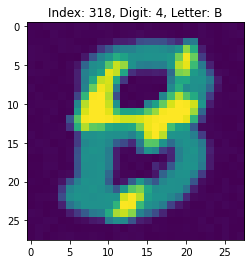

time: 227 ms (started: 2021-06-03 07:16:56 +00:00)


In [7]:
idx = 318
img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = train.loc[idx, 'digit']
letter = train.loc[idx, 'letter']

plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

글자 'B' 안에 숫자 '4'가 보인다.

In [8]:
# Train model

# feature/label 분리

x_train = train.drop(['id', 'digit', 'letter'], axis=1).values
x_train = x_train.reshape(-1, 28, 28, 1)
x_train = x_train/255

y = train['digit']
y_train = np.zeros((len(y), len(y.unique())))
for i, digit in enumerate(y):
    y_train[i, digit] = 1

time: 24.4 ms (started: 2021-06-03 07:16:58 +00:00)


In [9]:
# callback

reLR = ReduceLROnPlateau(patience=20,verbose=1,factor=0.5) #learning rate scheduler
early_stop = EarlyStopping(patience=30, verbose=1)
checkpoint = ModelCheckpoint('model.{epoch:02d}-{val_loss:.2f}.h5')

time: 2.05 ms (started: 2021-06-03 07:17:00 +00:00)


In [10]:
model = Sequential()

model.add(Conv2D(128,activation='relu',input_shape=(28,28,1),kernel_size=(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128,activation='relu',kernel_size=(2,2), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(256,activation='relu',kernel_size=(2,2), padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256,activation='relu',kernel_size=(2,2), padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.3))

model.add(Flatten())

model.add(Dense(1000,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))

model.add(Dense(10,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 128)       3328      
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 128)       65664     
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 128)       512       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 256)       1

In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(x_train, 
                    y_train, 
                    validation_split = 0.2, 
                    epochs=1000,
                    callbacks=[early_stop, checkpoint, reLR])

Epoch 1/1000
52/52 [==============================] - 49s 39ms/step - loss: 2.8523 - accuracy: 0.2982 - val_loss: 10.2141 - val_accuracy: 0.1073
Epoch 2/1000
52/52 [==============================] - 1s 19ms/step - loss: 1.4169 - accuracy: 0.5443 - val_loss: 18.9065 - val_accuracy: 0.1073
Epoch 3/1000
52/52 [==============================] - 1s 19ms/step - loss: 1.1873 - accuracy: 0.5961 - val_loss: 23.5052 - val_accuracy: 0.1073
Epoch 4/1000
52/52 [==============================] - 1s 18ms/step - loss: 0.8634 - accuracy: 0.6956 - val_loss: 25.8452 - val_accuracy: 0.1073
Epoch 5/1000
52/52 [==============================] - 1s 19ms/step - loss: 0.7118 - accuracy: 0.7587 - val_loss: 26.4359 - val_accuracy: 0.1073
Epoch 6/1000
52/52 [==============================] - 1s 19ms/step - loss: 0.6863 - accuracy: 0.7711 - val_loss: 27.9638 - val_accuracy: 0.1073
Epoch 7/1000
52/52 [==============================] - 1s 18ms/step - loss: 0.5359 - accuracy: 0.8237 - val_loss: 25.5302 - val_accuracy

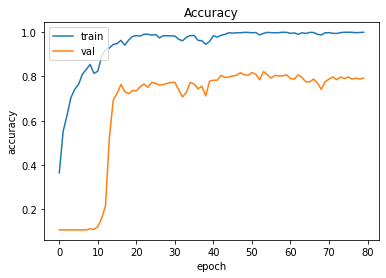

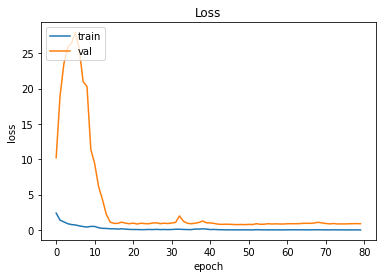

time: 994 ms (started: 2021-06-03 07:26:47 +00:00)


In [12]:
# 시각화

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
# Predict

x_test = test.drop(['id', 'letter'], axis=1).values
x_test = x_test.reshape(-1, 28, 28, 1)
x_test = x_test/255

submission['digit'] = np.argmax(model.predict(x_test), axis=1)
submission.head()

,id,digit
0,2049,6
1,2050,9
2,2051,8
3,2052,0
4,2053,3


time: 3.14 s (started: 2021-06-02 23:28:33 +00:00)


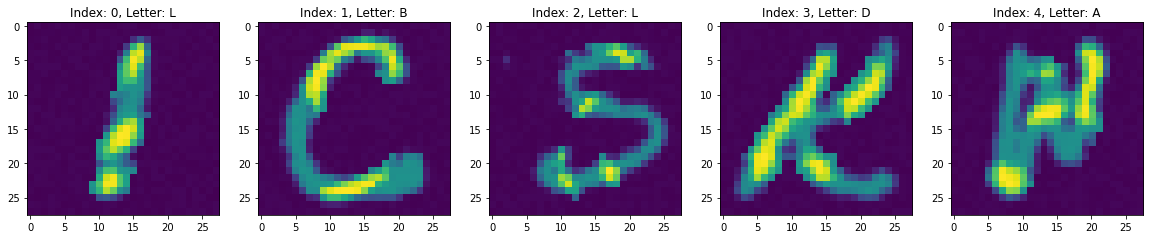

time: 814 ms (started: 2021-06-02 23:28:40 +00:00)


In [26]:
plt.figure(figsize=(20,4))
for i in range(5):
    img = x_test[i].reshape(28,28)
    letter = train.loc[i, 'letter']
    plt.subplot(1,5, i + 1)
    plt.title('Index: %i, Letter: %s'%(i, letter))
    plt.imshow(img)